In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [56]:
peptides=pd.read_csv(r"C:\Users\jshri\OneDrive\Desktop\train_peptides.csv")
proteins=pd.read_csv(r"C:\Users\jshri\OneDrive\Desktop\train_proteins.csv")
clinical_data=pd.read_csv(r"C:\Users\jshri\OneDrive\Desktop\train_clinical_data.csv")
supp_clinical=pd.read_csv(r"C:\Users\jshri\OneDrive\Desktop\supplemental_clinical_data.csv") 

In [57]:
all(proteins[['visit_id', 'UniProt']].value_counts() == 1)
df_p = peptides.merge(proteins[['visit_id', 'UniProt', 'NPX']], on=['visit_id','UniProt'], how='left')
df_p.head()
#I've rewritten visit_id for supplemental clinical data since it seems that its visit_id was different from convention in other files
supp_clinical['visit_id'] = supp_clinical['patient_id'].astype(str) + "_"+ supp_clinical['visit_month'].astype(str)

#Here we combine both main and supplemental clinical data into a single dataframe
df_cd = pd.concat([clinical_data, supp_clinical], ignore_index=True)
display(df_cd.info())
df_cd.melt(id_vars=['visit_id', 'patient_id', 'visit_month', 'upd23b_clinical_state_on_medication'], 
                   var_name='updrs', value_name='rating')
df_all = df_p.merge(df_cd[['visit_id','updrs_1','updrs_2','updrs_3','updrs_4','upd23b_clinical_state_on_medication']], on=['visit_id'], how='left')
df_all.info()
df_all['Peptide'].str.extract(r"(.\(.*?\))", expand=False).value_counts()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   visit_id                             4838 non-null   object 
 1   patient_id                           4838 non-null   int64  
 2   visit_month                          4838 non-null   int64  
 3   updrs_1                              4624 non-null   float64
 4   updrs_2                              4622 non-null   float64
 5   updrs_3                              4808 non-null   float64
 6   updrs_4                              2872 non-null   float64
 7   upd23b_clinical_state_on_medication  2410 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 302.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981834 entries, 0 to 981833
Data columns (total 12 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   visit_id                             981834 non-null  object 
 1   visit_month                          981834 non-null  int64  
 2   patient_id                           981834 non-null  int64  
 3   UniProt                              981834 non-null  object 
 4   Peptide                              981834 non-null  object 
 5   PeptideAbundance                     981834 non-null  float64
 6   NPX                                  981834 non-null  float64
 7   updrs_1                              941744 non-null  float64
 8   updrs_2                              941744 non-null  float64
 9   updrs_3                              932624 non-null  float64
 10  updrs_4                              495530 non-null  float64
 11  upd23b_clinic

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7,732430.0,10.0,6.0,15.0,NaN,NaN


In [58]:
options = ['SPQGLGAFTPVVR', 'ALEYIENLR', 'GMADQDGLKPTIDKPSEDSPPLEMLGPR', 'ESLQQMAEVTR', 'LEPGQQEEYYR', 'AYQGVAAPFPK', 'LQDLYSIVR',
          'SSGLVSNAPGVQIR', 'QALNTDYLDSDYQR', 'LVFFAEDVGSNK']
df_all = df_all[df_all['Peptide'].isin(options)]
df_all.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
15,55_0,0,55,O15240,AYQGVAAPFPK,107076.00,177775.0,10.0,6.0,15.0,NaN,NaN
26,55_0,0,55,O94919,QALNTDYLDSDYQR,23463.50,67567.6,10.0,6.0,15.0,NaN,NaN
491,55_0,0,55,P04180,LEPGQQEEYYR,8618.61,79350.6,10.0,6.0,15.0,NaN,NaN
492,55_0,0,55,P04180,SSGLVSNAPGVQIR,33354.70,79350.6,10.0,6.0,15.0,NaN,NaN
519,55_0,0,55,P05067,LVFFAEDVGSNK,57869.10,344149.0,10.0,6.0,15.0,NaN,NaN


In [59]:
import pandas as pd
df = df_all
# Create a new column that checks whether all UPDRS values are 0
df['all_UPDRS_0'] = ((df['updrs_1'] == 0) & (df['updrs_2'] == 0) &
                     (df['updrs_3'] == 0) & (df['updrs_4'] == 0))

# Group the control patients based on whether all UPDRS values are 0
control_groups = df[
                    (df['all_UPDRS_0'] == True)]

# Print the resulting groups
control_groups.head(40)
num_patients = control_groups['visit_month'].nunique()
print(num_patients)

2


In [60]:
df_all = df_all.drop(['updrs_4', 'upd23b_clinical_state_on_medication'], axis=1)

In [61]:
updrs_cutoffs = {'updrs_1': 1.5, 'updrs_2': 5, 'updrs_3': 13}

In [62]:
# Create a new column indicating whether an individual is less likely to have Parkinson's disease
df['no_pd'] = (df_all['updrs_1'] <= updrs_cutoffs['updrs_1']) & (df_all['updrs_2'] <= updrs_cutoffs['updrs_2']) &  (df_all['updrs_3'] <= updrs_cutoffs['updrs_3'])

In [63]:
# Separate no_pd == True (control) and no_pd == False (PD) into different dataframes
control_df = df[df['no_pd'] == True]
pd_df = df[df['no_pd'] == False]

# Drop updrs_4 and all_UPDRS_0 columns
control_df = control_df.drop(['updrs_4', 'all_UPDRS_0'], axis=1)
pd_df = pd_df.drop(['updrs_4', 'all_UPDRS_0'], axis=1)

In [64]:
control_df = control_df.drop(['visit_id', 'visit_month', 'UniProt', 'NPX','updrs_1', 'updrs_2', 'updrs_3', 'upd23b_clinical_state_on_medication' ,'no_pd'  ], axis=1) 
control_df.head()

,patient_id,Peptide,PeptideAbundance
3633,3636,AYQGVAAPFPK,41799.70
4097,3636,LEPGQQEEYYR,5438.49
4098,3636,SSGLVSNAPGVQIR,9651.65
4124,3636,LVFFAEDVGSNK,27979.10
4293,3636,ALEYIENLR,22878.40


In [65]:
pd_df = pd_df.drop(['visit_id', 'visit_month', 'UniProt', 'NPX','updrs_1', 'updrs_2', 'updrs_3', 'upd23b_clinical_state_on_medication' ,'no_pd'  ], axis=1)
pd_df.head()

,patient_id,Peptide,PeptideAbundance
15,55,AYQGVAAPFPK,107076.00
26,55,QALNTDYLDSDYQR,23463.50
491,55,LEPGQQEEYYR,8618.61
492,55,SSGLVSNAPGVQIR,33354.70
519,55,LVFFAEDVGSNK,57869.10


In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [67]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [68]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

# Define a list of hyperparameters to iterate over
learning_rates = [0.1, 0.2, 0.5]
max_depths = [3, 4, 5]

# Initialize an empty dictionary to store accuracy scores
accuracy_scores = {}

# Separate no_pd == True (control) and no_pd == False (PD) into different dataframes
control_df = df[df['no_pd'] == True]
pd_df = df[df['no_pd'] == False]
control_df.fillna(0, inplace=True)
pd_df.fillna(0, inplace=True)



# Drop updrs_4 and all_UPDRS_0 columns
control_df = control_df.drop(['updrs_4', 'all_UPDRS_0'], axis=1)
pd_df = pd_df.drop(['updrs_4', 'all_UPDRS_0'], axis=1) 

# Split the data into training and testing sets

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    pd.concat([control_df, pd_df])[['PeptideAbundance']],
    pd.concat([control_df, pd_df])['no_pd'].astype(int),
    test_size=0.2, 
    random_state=7)

for lr in learning_rates:
    for depth in max_depths:
        model = XGBClassifier(scale_pos_weight=1,
                              learning_rate=lr,  
                              colsample_bytree = 0.9,
                              subsample = 0.3,
                              objective='reg:logistic', 
                              n_estimators=1000, 
                              reg_alpha = 0.3,
                              max_depth=depth, 
                              gamma=1)
        model.fit(X_train,y_train)
        accuracy = model.score(X_test, y_test)
        accuracy_scores[(lr, depth)] = accuracy

# Test the model on the testing set
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

C:\Users\jshri\AppData\Local\Temp\ipykernel_7400\674179489.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_df.fillna(0, inplace=True)
C:\Users\jshri\AppData\Local\Temp\ipykernel_7400\674179489.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_df.fillna(0, inplace=True)


Accuracy: 0.830068819481207


In [69]:
accuracy = model.score(X_test, y_test)
accuracy_scores[(lr, depth)] = accuracy

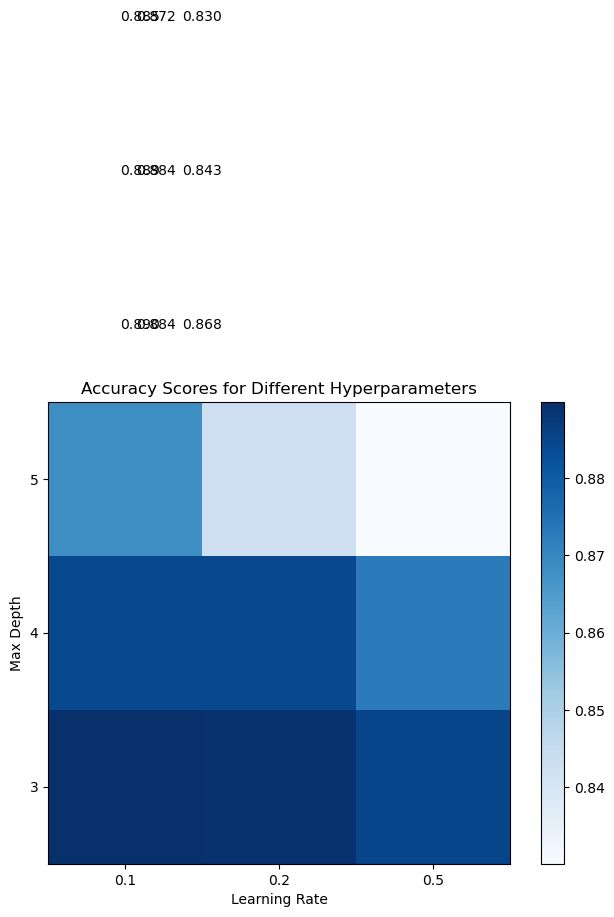

In [77]:
plt.figure(figsize=(8,6))
plt.title("Accuracy Scores for Different Hyperparameters")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
for lr in learning_rates:
    for depth in max_depths:
        score = accuracy_scores[(lr, depth)]
        plt.text(lr, depth, "{:.3f}".format(score), ha='center', va='center')
plt.imshow([[accuracy_scores[(lr, depth)] for depth in max_depths] for lr in learning_rates],
           cmap='Blues', interpolation='nearest', origin='lower')
plt.xticks(range(len(learning_rates)), learning_rates)
plt.yticks(range(len(max_depths)), max_depths)
plt.colorbar()
plt.show()

C:\Users\jshri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\jshri\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


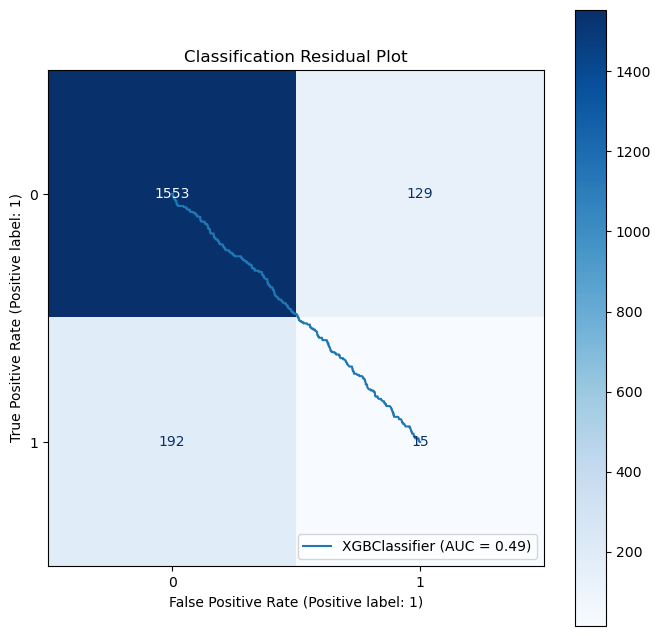

In [78]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

# Predict classes for the testing set
y_pred = model.predict(X_test)

# Create the classification residual plot
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap='Blues')
ax.set_title("Classification Residual Plot")
plot_roc_curve(model, X_test, y_test, ax=ax)
plt.show()